In [1]:
%load_ext autotime
RANDOM_STATE = 42

## Packages

In [2]:
import pandas as pd
from os.path import abspath
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

time: 31.6 s


## Dataset Load

In [3]:
dataset = pd.read_csv(abspath('./data.csv'))
dataset['Sentiment'] = dataset['Sentiment'].str.lower()
dataset['target'] = dataset['outcome'] == 'Yes'
dataset.head(10)

,Timestamp,Gender,Age,Did you take COVID 19 vaccine?,outcome,Sentiment,target
0,2/16/2021 11:22:08,Male,40-60,Yes,Yes,it will keep us safe from covid-19. i think ev...,True
1,2/16/2021 11:23:25,Male,20-40,No,Yes,we should be taking vaccines as it reduces the...,True
2,2/16/2021 11:25:06,Male,20-40,No,Yes,vaccines are helpful for us. we should take a ...,True
3,2/16/2021 11:25:30,Male,20-40,No,Yes,because this vaccine has around 80 to 90% accu...,True
4,2/16/2021 11:25:38,Female,20-40,No,Yes,it will be good for humanity.,True
5,2/16/2021 11:25:45,Female,20-40,No,Yes,everybody should take covid vaccine,True
6,2/16/2021 11:26:04,Male,20-40,No,Yes,let's get vaccinated. it is 100% safe.,True
7,2/16/2021 11:26:47,Male,20-40,No,Yes,it's good to take covid vaccine,True
8,2/16/2021 11:27:36,Male,0-20,No,Yes,yes. i support this vaccine program. because i...,True
9,2/16/2021 11:28:41,Male,20-40,No,Yes,100% safe to the user. people should hurry bef...,True


time: 217 ms


## Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Sentiment'], dataset['target'], test_size=0.2, random_state=RANDOM_STATE)

time: 2.2 ms


In [5]:
X_train.head(5)

1335    bangladesh kicked off its coronavirus vaccinat...
579     i can't risk my closed ones' lives to experiment.
1137    no comments on the bad sides. focus on the bri...
48         i don't trust doctors. we don't need vaccines.
155     if you list any cause of death as covid are co...
Name: Sentiment, dtype: object

time: 3.51 ms


In [6]:
y_train.head(5)

1335    False
579     False
1137     True
48      False
155     False
Name: target, dtype: bool

time: 2.77 ms


## Model

In [7]:
# Model Config
model_metrices =['accuracy']
batch_size = 64
embedding_dimensions = 16
loss_function = BinaryCrossentropy()
max_sequence_length = 10
num_distinct_words = 5000
optimizer = 'adam'
validation_split = 0.2

time: 768 µs


In [8]:
tokenizer = Tokenizer(num_words=num_distinct_words)
tokenizer.fit_on_texts(X_train)

time: 26.4 ms


In [9]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

time: 25.3 ms


In [10]:
padded_X_train = pad_sequences(X_train, maxlen=max_sequence_length, value=0) # 0.0 because it corresponds with <PAD>
padded_X_test = pad_sequences(X_test, maxlen=max_sequence_length, value=0)

time: 11 ms


In [11]:
lstm_input = Input(shape=(max_sequence_length))
lstm_layer = Embedding(num_distinct_words, embedding_dimensions, input_length = max_sequence_length)(lstm_input)

lstm_layer = LSTM(64)(lstm_layer)

lstm_layer = Dense(32, activation='relu')(lstm_layer)

lstm_output = Dense(1, activation='sigmoid')(lstm_layer)

time: 8.1 s


In [12]:
lstm_model = Model(inputs=lstm_input, outputs=lstm_output)
lstm_model.compile(optimizer=optimizer, loss=loss_function, metrics=model_metrices)

time: 27.1 ms


In [13]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 16)            80000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 102,849
Trainable params: 102,849
Non-trainable params: 0
_________________________________________________________________
time: 2.99 ms


In [14]:
earlyStopCb = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=3)
lstm_history = lstm_model.fit(padded_X_train, y_train, batch_size=batch_size, epochs=100, validation_split=validation_split, callbacks=[earlyStopCb])

Epoch 1/100
15/15 [==============================] - 30s 66ms/step - loss: 0.6926 - accuracy: 0.5254 - val_loss: 0.6901 - val_accuracy: 0.5088
Epoch 2/100
15/15 [==============================] - 0s 7ms/step - loss: 0.6852 - accuracy: 0.5218 - val_loss: 0.6735 - val_accuracy: 0.5619
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 0.6374 - accuracy: 0.7721 - val_loss: 0.5840 - val_accuracy: 0.6947
Epoch 4/100
15/15 [==============================] - 0s 7ms/step - loss: 0.4442 - accuracy: 0.8085 - val_loss: 0.6222 - val_accuracy: 0.7257
Epoch 5/100
15/15 [==============================] - 0s 7ms/step - loss: 0.2892 - accuracy: 0.8924 - val_loss: 0.5333 - val_accuracy: 0.7478
Epoch 6/100
15/15 [==============================] - 0s 7ms/step - loss: 0.2126 - accuracy: 0.9313 - val_loss: 0.6413 - val_accuracy: 0.7257
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: 0.2393 - accuracy: 0.8995 - val_loss: 0.5566 - val_accuracy: 0.7434
Epoch 8/100

## Plotting

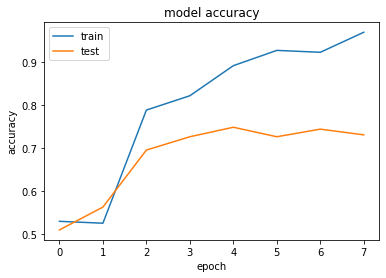

time: 130 ms


In [20]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
lstm_results = (lstm_model.predict(padded_X_test)).round()

time: 57.4 ms


In [22]:
lstm_report = classification_report(y_test, lstm_results)

time: 5.88 ms


In [23]:
print(lstm_report)

              precision    recall  f1-score   support

       False       0.67      0.75      0.71       117
        True       0.81      0.74      0.77       165

    accuracy                           0.74       282
   macro avg       0.74      0.75      0.74       282
weighted avg       0.75      0.74      0.75       282

time: 622 µs
